In [16]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("Dataset/dataset_all_features.csv")

# Primeras filas
print("=== Primeras filas ===")
print(df.head())

# Información general
print("\n=== Info del dataset ===")
print(df.info())

# Valores nulos
print("\n=== Valores nulos por columna ===")
print(df.isnull().sum())

# Estadísticas básicas (solo numéricas)
print("\n=== Estadísticas descriptivas ===")
print(df.describe())

# Distribución de la etiqueta (si existe columna 'label' o similar)
if 'label' in df.columns:
    print("\n=== Distribución de la variable target (label) ===")
    print(df['label'].value_counts())


=== Primeras filas ===
                                       flow_id   packets     bytes  duration  \
0      124.192.86.248:61079-68.31.89.180:53-17 -0.065342 -0.042128 -0.402400   
1   61.139.26.122:41416-113.233.206.8:38191-17 -0.065342 -0.042129 -0.402400   
2     61.139.26.122:1433-218.88.239.56:62217-6 -0.064685 -0.042098 -0.392477   
3  111.173.128.39:28755-61.139.26.115:58433-17 -0.065342 -0.042072 -0.402400   
4   112.50.28.154:27912-61.139.26.115:59957-17 -0.065342 -0.042072 -0.402400   

   avg_pkt_size  throughput  syn_count  ack_count  fin_count  rst_count  ...  \
0     -0.496475   -0.036964  -0.673749  -0.056137  -0.609463  -0.076601  ...   
1     -0.504662   -0.036964  -0.673749  -0.056137  -0.609463  -0.076601  ...   
2     -0.553785   -0.036953  -0.673749  -0.054309  -0.609463   0.327434  ...   
3     -0.132143   -0.036958  -0.673749  -0.056137  -0.609463  -0.076601  ...   
4     -0.132143   -0.036958  -0.673749  -0.056137  -0.609463  -0.076601  ...   

   control_flag

In [17]:
import pandas as pd

df = pd.read_csv("Dataset/dataset_all_features.csv")  # cambia el nombre real

print(df['class'].value_counts())

class
web-browsing       3045
video              3045
interactive-app    3045
network-storage    3045
mail               3045
Name: count, dtype: int64


Clases codificadas: ['interactive-app' 'mail' 'network-storage' 'video' 'web-browsing']
✅ Mejores hiperparámetros encontrados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

=== Reporte de clasificación en VALIDATION ===
                 precision    recall  f1-score   support

interactive-app       0.45      0.54      0.49       609
           mail       0.62      0.61      0.61       609
network-storage       0.71      0.57      0.64       609
          video       0.81      0.83      0.82       609
   web-browsing       0.62      0.62      0.62       609

       accuracy                           0.63      3045
      macro avg       0.64      0.63      0.64      3045
   weighted avg       0.64      0.63      0.64      3045



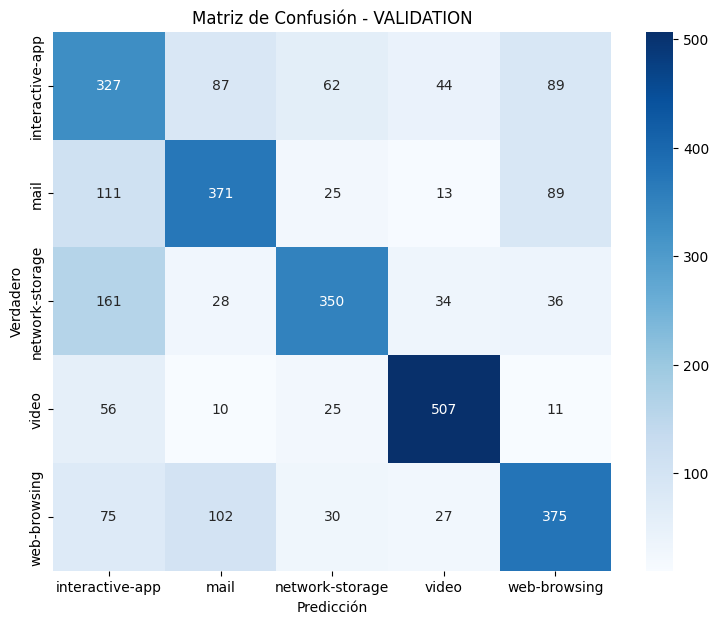

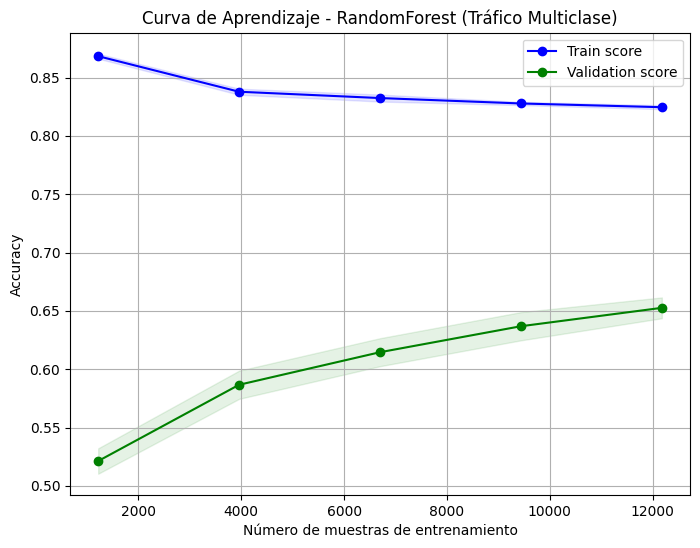


Scores finales en VALIDATION:
Accuracy: 0.634
F1-score (macro): 0.636
F1-score (weighted): 0.636
Accuracy promedio CV: 0.653 ± 0.009


In [18]:
# train_traffic_features_full.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# ==============================
# 1️⃣ Cargar dataset
# ==============================
df = pd.read_csv("Dataset/dataset_all_features.csv")  # Ajusta el path si es necesario

# ==============================
# 2️⃣ Preparar features y etiquetas
# ==============================
X = df.drop(columns=['flow_id','class'])
y = df['class']

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Clases codificadas:", le.classes_)

# ==============================
# 3️⃣ División Train/Test/Validation
# ==============================
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Aproximadamente 60% train, 20% test, 20% validation

# ==============================
# 4️⃣ GridSearchCV para RandomForest
# ==============================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Mejores hiperparámetros encontrados: {grid.best_params_}")

# ==============================
# 5️⃣ Evaluación en VALIDATION
# ==============================
best_clf = grid.best_estimator_
y_val_pred = best_clf.predict(X_val)

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION")
plt.show()

# ==============================
# 6️⃣ Curva de aprendizaje
# ==============================
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y_encoded, cv=cv_outer, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title("Curva de Aprendizaje - RandomForest (Tráfico Multiclase)")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ==============================
# 7️⃣ Scores finales
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")

# ==============================
# 8️⃣ Validación cruzada completa
# ==============================
cv_scores = cross_val_score(best_clf, X, y_encoded, cv=cv_outer, scoring='accuracy')
print(f"Accuracy promedio CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
